# Folder-wise Fast Microscopy Picture Analysis
The following code opens a folder of the Keyence Microscope and automatically sets ROIs to the darkest and brightest portions of the picture. Consequently it removes the background through the ROIs at the darkest positions and calculates the mean fluorescence at the brighter spots. 

In [1]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tkinter import Tk
import tkinter
import imagecodecs
from tkinter.filedialog import askdirectory
import os
from skimage import filters, measure, morphology, draw
import math
import pandas as pd

In [2]:
tkinter._test()
plt.close('all')

In [3]:
# Use tkinter to open a file dialog and select the folder with images
def select_folder():
    Tk().withdraw()  # We don't want a full GUI, so keep the root window from appearing
    folder_path = askdirectory(title="Select Folder with Channel TIFF Images")
    return folder_path

folder_path = select_folder()

# Function Definitions

In [4]:
# Normalize images for display
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [5]:
# Function to process a single set of 4-channel images and return mean fluorescence values
def process_images(base_name, lower_thresh, upper_thresh, background_threshold, radius_factor):
    channel1_path = base_name + "_CH1.tif"
    channel2_path = base_name + "_CH2.tif"
    channel3_path = base_name + "_CH3.tif"
    channel4_path = base_name + "_CH4.tif"

    # Load the images
    channel1 = tiff.imread(channel1_path)[:, :, 2] # Blue Channel  
    channel2 = tiff.imread(channel2_path)[:, :, 1] # Green Channel
    channel3 = tiff.imread(channel3_path)[:, :, 0] # Red Channel
    channel4 = tiff.imread(channel4_path)[:, :, 0] # Far Red Channel

    # Combine channels into a single multi-channel image for convenience
    image = np.stack((channel1, channel2, channel3, channel4), axis=-1)

    fig, axs = plt.subplots(2, 2)

    # Display one of the channels (normalized)
    axs[0,0].imshow(normalize(tiff.imread(channel1_path)), cmap='gray')
    axs[0,0].set_title('Channel 1 (Normalized)')
    axs[0,1].imshow(normalize(tiff.imread(channel2_path)), cmap='gray')
    axs[0,1].set_title('Channel 2 (Normalized)')
    axs[1,0].imshow(normalize(tiff.imread(channel3_path)), cmap='gray')
    axs[1,0].set_title('Channel 3 (Normalized)')
    axs[1,1].imshow(normalize(tiff.imread(channel4_path)), cmap='gray')
    axs[1,1].set_title('Channel 4 (Normalized)')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show()

    # Find minima below a threshold to define background ROIs
    background_thresh = channel4 < background_threshold

    # Label the background regions
    background_labels = measure.label(background_thresh)
    background_props = measure.regionprops(background_labels)

    # Create bounding boxes around the detected background contours to define background ROIs
    background_rois = []

    for prop in background_props:
        minr, minc, maxr, maxc = prop.bbox[:4]
        background_rois.append((minc, minr, maxc - minc, maxr - minr))

    # Display background ROIs on channel 1
    background_roi_image = np.stack([normalize(channel4)]*3, axis=-1)  # Convert to RGB

    for roi in background_rois:
        x, y, w, h = roi
        background_roi_image[y:y+h, x:x+w] = [1, 0, 0]  # Red for background ROIs

    plt.imshow(background_roi_image)
    plt.title('Background ROIs on Channel 4')
    plt.show()

    # Initialize a list to store mean fluorescence values
    mean_fluorescence = {f'Channel {i+1}': [] for i in range(image.shape[2])}
    background_values = {f'Channel {i+1}': [] for i in range(image.shape[2])}

    # Calculate mean background values for each channel
    for channel_index in range(image.shape[2]):
        channel = image[:, :, channel_index]
        
        for roi in background_rois:
            x, y, w, h = roi
            roi_area = channel[y:y+h, x:x+w]
            mean_background = np.mean(roi_area)
            background_values[f'Channel {channel_index+1}'].append(mean_background)

    mean_background_value = []
    # Subtract background from the entire image
    background_subtracted_image = np.copy(image)
    for channel_index in range(image.shape[2]):
        mean_background_value.append(np.mean(background_values[f'Channel {channel_index+1}']))
        background_subtracted_image[:, :, channel_index] -= np.minimum(math.floor(mean_background_value[channel_index]), background_subtracted_image[:, :, channel_index])

    # Apply thresholds to find maximum values in the background-subtracted channel 1, avoiding very bright spots
    # Mask out very bright spots
    thresh = (background_subtracted_image[:, :, 3] > lower_thresh) & (background_subtracted_image[:, :, 3] < upper_thresh)

    # Label the thresholded regions
    labels = measure.label(thresh)
    props = measure.regionprops(labels)

    # Create circular ROIs around detected points
    rois = []

    for prop in props:
        y, x = prop.centroid
        radius = radius_factor # * np.sqrt(prop.area / np.pi)
        if prop.area < 1000:
            rois.append((int(x), int(y), int(radius)))

    # Display circular ROIs on the background-subtracted channel 1
    roi_image = np.stack([normalize(background_subtracted_image[:, :, 3])]*3, axis=-1)  # Convert to RGB

    for roi in rois:
        x, y, radius = roi
        rr, cc = draw.disk((y, x), radius, shape=roi_image.shape)
        roi_image[rr, cc] = [0, 1, 0]  # Green for ROIs

    plt.imshow(roi_image)
    plt.title('ROIs on Background-Subtracted Channel 4')
    plt.show()

    # Measure mean fluorescence in the ROIs for all channels
    for channel_index in range(image.shape[2]):
        channel = background_subtracted_image[:, :, channel_index]

        for roi in rois:
            x, y, radius = roi
            rr, cc = draw.disk((y, x), radius, shape=channel.shape)
            roi_area = channel[rr, cc]
            mean_value = np.mean(roi_area)
            mean_fluorescence[f'Channel {channel_index+1}'].append(mean_value)

    return mean_fluorescence

    # mean_fluorescence_value = np.array([])

    # # Calculate mean fluorescence values for each channel
    # for channel_index in range(image.shape[2]):
    #     mean_fluorescence_value = np.append(mean_fluorescence_value, np.mean(mean_fluorescence[f'Channel {channel_index+1}']))

    # # Print the results
    # # for channel, values in mean_fluorescence.items():
    # #     print(f'{channel}: {values}')

    # print("mean_fluorescence_value: ", mean_fluorescence_value.tolist())
    # print("VP16 to GFP ratio: ", mean_fluorescence_value[1]/mean_fluorescence_value[3])

# Main Workflow Point

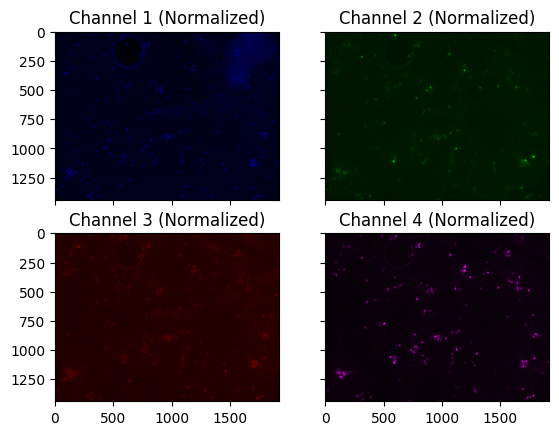

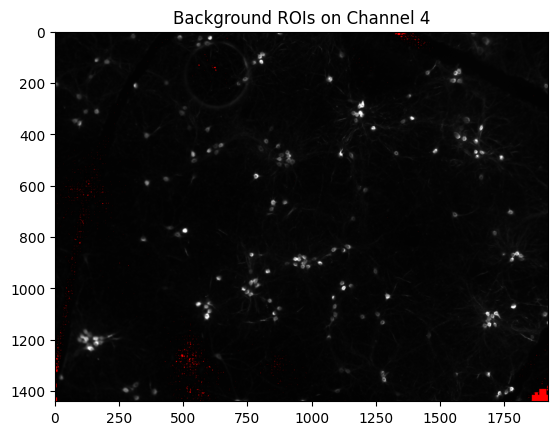

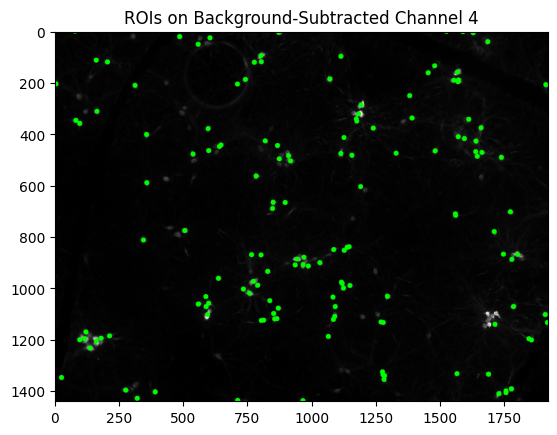

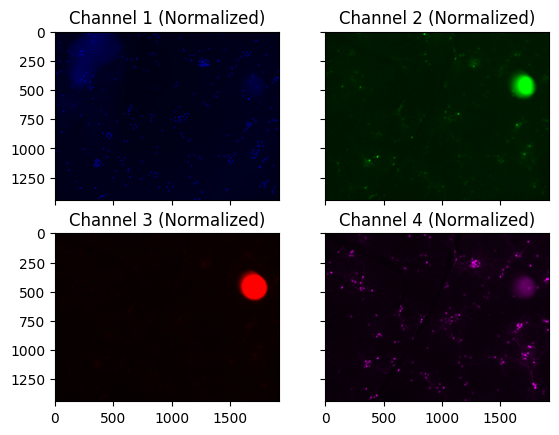

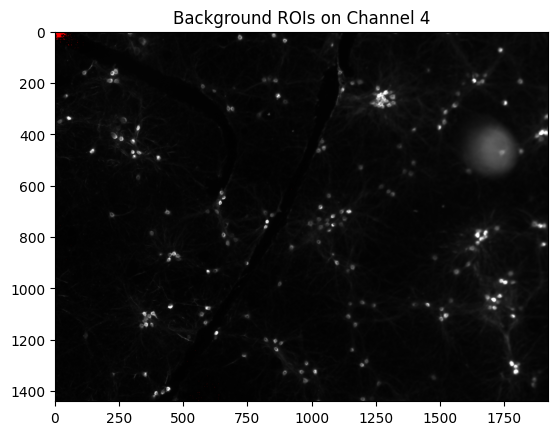

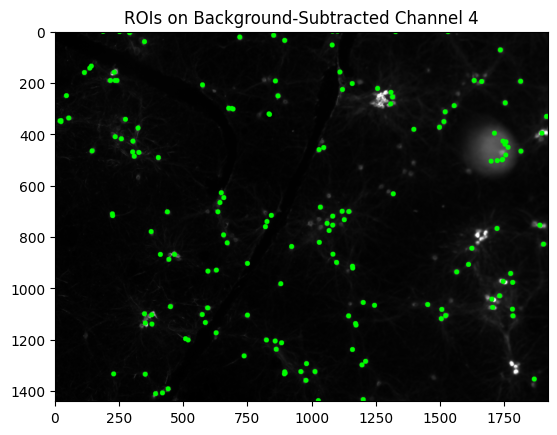

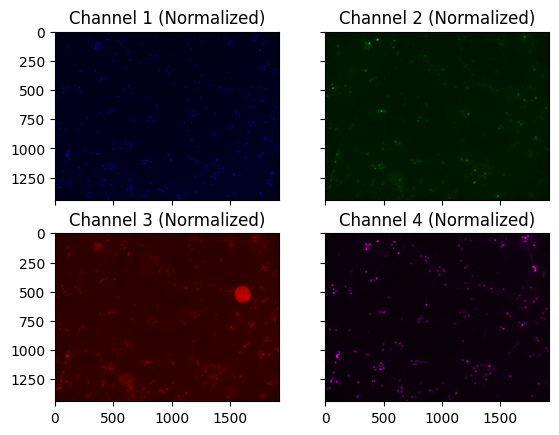

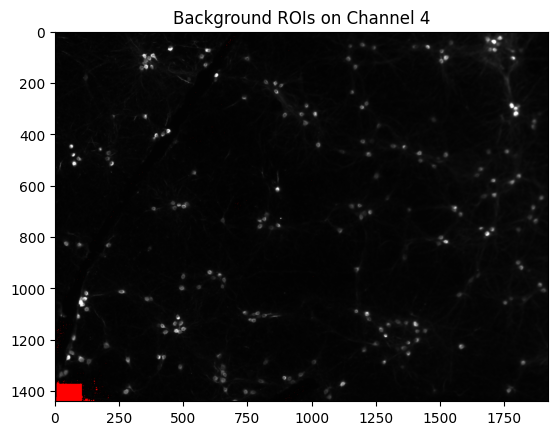

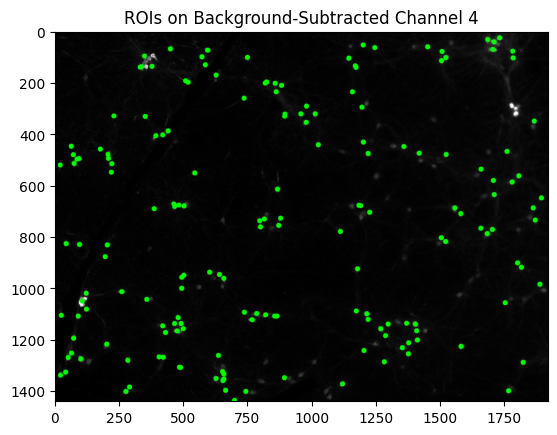

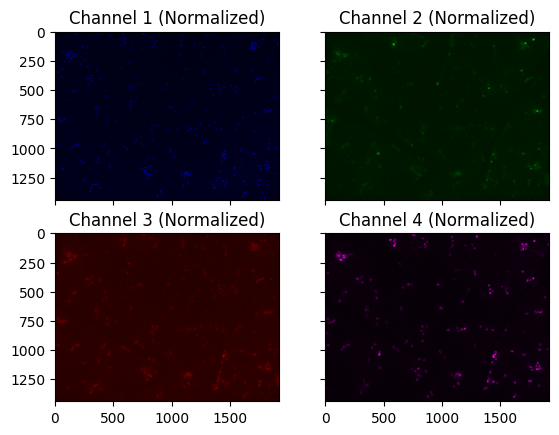

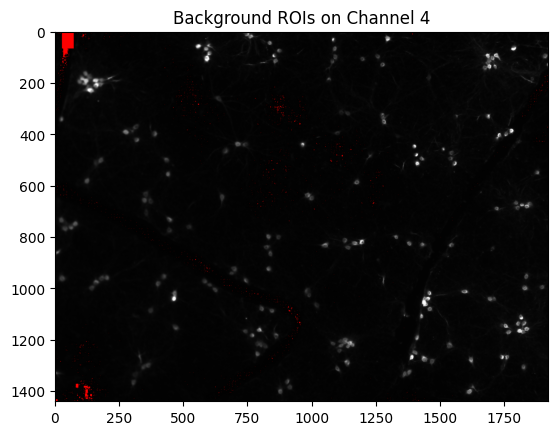

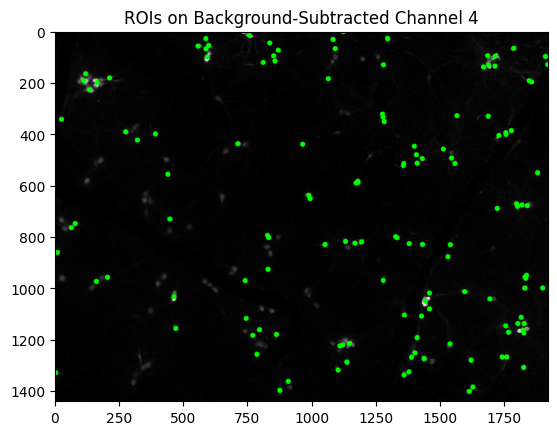

Processing complete. Results saved to mean_fluorescence_results.csv


In [8]:
# Process all sets of images in the folder and collect the results
results = []

# Thresholds for ROI detection and background exclusion
lower_thresh = 20000  # Adjust this value based on your needs
upper_thresh = 64000  # Adjust this value to exclude very bright spots
background_threshold = 1800  # Adjust this value based on your needs
radius_factor = 10  # Factor to determine the radius of the circular ROIs

for filename in os.listdir(folder_path):
    if filename.endswith("_CH1.tif"):
        base_name = os.path.join(folder_path, filename.replace("_CH1.tif", ""))
        mean_fluorescence = process_images(base_name, lower_thresh, upper_thresh, background_threshold, radius_factor)
        
        # Collect results into a list of dictionaries for easy conversion to DataFrame
        result = {'Base Name': base_name}
        for channel, values in mean_fluorescence.items():
            result[channel] = np.mean(values)
        results.append(result)

# Convert the results to a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(os.path.join(folder_path, 'mean_fluorescence_results.csv'), index=False)

print("Processing complete. Results saved to mean_fluorescence_results.csv")


In [7]:
plt.close("all")